In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from scipy import stats

In [2]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
data_df = pd.read_csv(path+'/Rawdata_2017-19.csv', sep=',', header=0)
#data_df.reset_index(inplace=True)

In [3]:
data_df['date'] = pd.DatetimeIndex(data_df['date'])

# 1. Data & Packages

In [5]:
data_df["inquiry_with_description"] = data_df["inquiry_name"] + ' ' + data_df["brief_description"]
data_df.head(2)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.
1,850,120985098,850,2017-01-01,12:01:12 AM,2017-01-01T00:01:12.000,NYPD,New York City Police Department,Vehicle Blocking Driveway Complaint,Report a vehicle that is blocking a driveway.,CSMS SR,Vehicle Blocking Driveway Complaint Report a v...


In [6]:
unique_inq_df = pd.DataFrame(data_df['inquiry_with_description'].unique()).rename(columns={0:'Inquiry_names'})
unique_inq_df

,Inquiry_names
0,Language Assistance Connect to Language Line.
1,Vehicle Blocking Driveway Complaint Report a v...
2,Apartment Maintenance Complaint Report a maint...
3,Noise from Neighbor Report a noisy neighbor.
4,Find a Police Precinct or PSA by Name Find a s...
...,...
6801,Taxi Complaint Report a problem with a taxi dr...
6802,"New Year's Day Wednesday, January 1st is New Y..."
6803,Fuel Truck Inspection Get an inspection of fue...
6804,Home Repair Assistance for Seniors Learn about...


# 2. Embeddings

In [7]:
#%pip install sentence-transformers

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
model4 = SentenceTransformer('all-MiniLM-L6-v2')
embeddings4 = model4.encode(unique_inq_df['Inquiry_names'], show_progress_bar=True)

Batches: 100%|██████████| 213/213 [00:50<00:00,  4.25it/s]


In [10]:
import pickle
# Save the embeddings to a file
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/05-embeddings'

with open(path+"/embeddings_inq_2017-2019.pickle", "wb") as file:
    pickle.dump(embeddings4, file)

In [11]:
import pickle
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/05-embeddings'

# Load the embeddings from the file
with open(path+"/embeddings_inq_2017-2019.pickle", "rb") as file:
    embeddings4 = pickle.load(file)

In [12]:
embeddings4.shape

(6806, 384)

In [13]:
unique_inq_df.shape

(6806, 1)

# 3. Clustering

Finding optimum number of clusters

In [14]:
from sklearn.cluster import KMeans
#%pip install yellowbrick

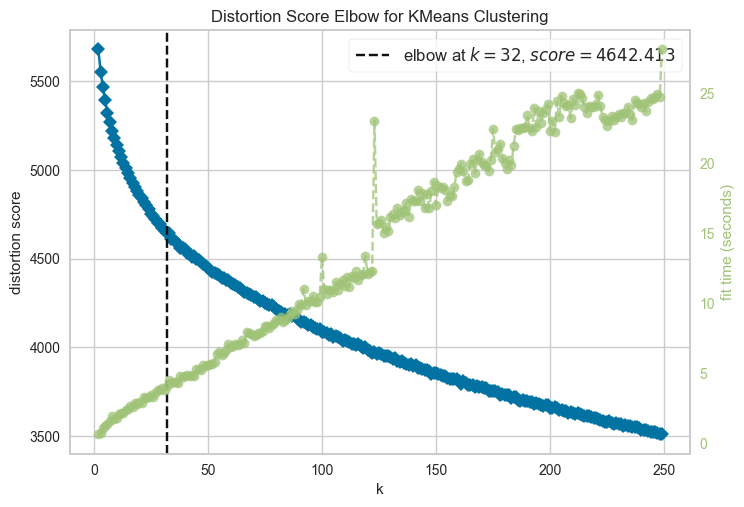

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,250), timings= True)
visualizer.fit(embeddings4)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

Plotting clusters with UMAP dimensionailty reduction

In [16]:
#%pip install umap-learn

In [17]:
import matplotlib.pyplot as plt
import umap
umap_embeddings = umap.UMAP(
           n_components=2,
           min_dist=0.0).fit_transform(embeddings4)

In [18]:
umap_embeddings.shape

(6806, 2)

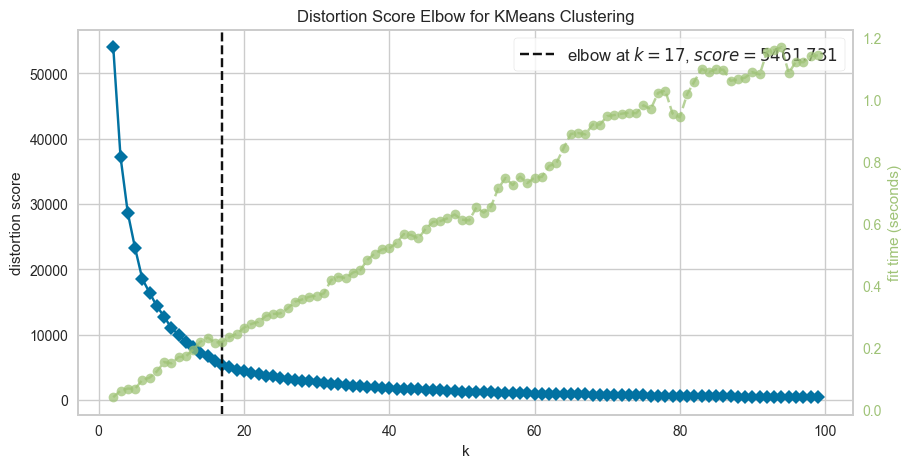

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,100), timings= True)
visualizer.fit(umap_embeddings)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

The elbow method involves plotting the distortion score for different values of K, and selecting the value of K where the decrease in the distortion score starts to level off, forming an elbow shape. The idea is to choose a value of K that achieves a relatively low distortion score while avoiding overfitting (i.e., having too many clusters).

### Assigning clusters

In [ ]:
umap_embeddings.shape

(6806, 2)

In [21]:
from sklearn.cluster import KMeans
n_clusters=16
kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(umap_embeddings)
# Obtain the cluster labels for each embedding
cluster_labels = kmeans.predict(umap_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()
cls_dist

7     865
9     625
11    589
5     573
3     564
2     500
4     477
6     469
1     436
0     347
14    326
12    304
15    293
8     218
13    186
10     34
dtype: int64

In [24]:
data_df.head(1)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.


In [25]:
# Create a new dataframe with the cluster labels
# Merge the original dataframe and the cluster labels dataframe on the index
clustered_df = unique_inq_df.merge(pd.DataFrame({'cluster_label': cluster_labels}), left_index=True, right_index=True)

# Merging embeddings
clustered_df = clustered_df.merge(pd.DataFrame(umap_embeddings), left_index=True, right_index=True)
clustered_df.rename(columns={0:'embed_0',1:'embed_1'},inplace=True)
clustered_df = data_df.merge(clustered_df, left_on='inquiry_with_description', right_on='Inquiry_names')

In [26]:
clustered_df[clustered_df['cluster_label'] == 8][['inquiry_name']].value_counts()

inquiry_name                                          
Bus or Subway - Information and Complaint                 106955
Lost Property in a Taxi - Medallion Number Known           39934
Buses and Subways                                          32647
MetroCard - Information and Complaint                      29307
Lost Property in a Taxi - Medallion Number Unknown         28169
                                                           ...  
Overcharge - Car Wash                                          6
Taxi Complaint - E-Hail - Unclean Condition or Odor            5
Taxi Complaint - E-Hail - Credit Card - Driver Refusal         3
Electric Taxi                                                  2
Overcharge - Cleaning of Cooling Towers                        2
Length: 193, dtype: int64

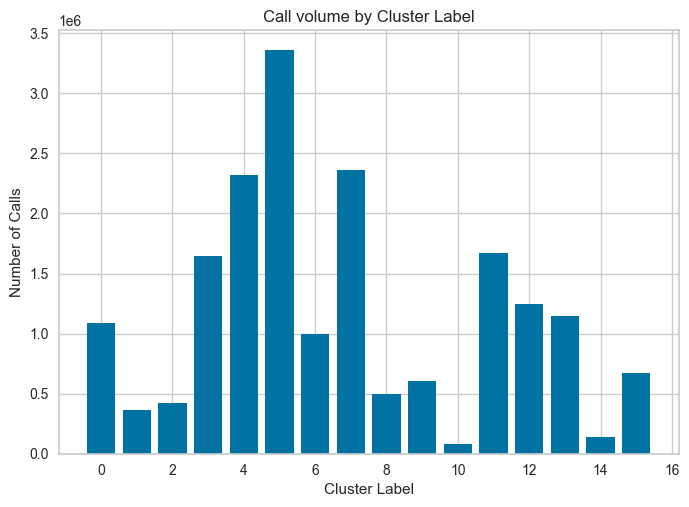

In [27]:
# Count the number of data points in each cluster
counts = clustered_df['cluster_label'] .value_counts()

# Plot a histogram of the counts
plt.bar(counts.index, counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Calls')
plt.title('Call volume by Cluster Label')
plt.show()

Calculate the cluster centroids

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

# Find the closest text to each centroid
centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_
text_data = clustered_df['inquiry_name'] # inquiry_with_description

clustered_df['Centroid_text'] = 'None'
for i in range(len(centroids)):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_text = text_data.iloc[cluster_indices]
    centroid_similarities = cosine_similarity(clustered_df[['embed_0', 'embed_1']].values, centroids[i].reshape(1, -1))#.flatten()
    
    # Assign the maximum similarity score to each data point
    #clustered_df[f'similarity_to_centroid_{i}'] = centroid_similarities.max(axis=1)
    closest_text_index = np.argmax(centroid_similarities)
    #print(closest_text_index)
    closest_text = text_data.iloc[closest_text_index]
    closest_agency = clustered_df['agency'].iloc[closest_text_index]
    print("Cluster ", i, "centroid text:", closest_text)
    print("closest_agency:", closest_agency)
    clustered_df['Centroid_text'].loc[(clustered_df['cluster_label']==i)] = closest_text

Cluster  0 centroid text: Gas Service and Billing
closest_agency: 0
Cluster  1 centroid text: U.S. Postal Service Consumer Hotline
closest_agency: USPS
Cluster  2 centroid text: Summer School
closest_agency: 0
Cluster  3 centroid text: Carpool or RideMatch
closest_agency: 0
Cluster  4 centroid text: Reclaim a Towed Vehicle - NYPD
closest_agency: DOF
Cluster  5 centroid text: Waterway Complaint
closest_agency: 0
Cluster  6 centroid text: Neighborhood Housing Services Home Repair Program
closest_agency: HPD
Cluster  7 centroid text: Living Wage Increase for Subsidized Projects
closest_agency: CHALL
Cluster  8 centroid text: Congestion Surcharge for Taxis and For-Hire Vehicles
closest_agency: NYSTAX
Cluster  9 centroid text: Nurses for Pregnant Women 18 Years Old and Over
closest_agency: DOHMH
Cluster  10 centroid text: Fire Hydrant Lock Removal Request
closest_agency: DEP
Cluster  11 centroid text: Smokeless Tobacco Law Information
closest_agency: DOHMH
Cluster  12 centroid text: Find a 

In [29]:
clustered_df.head(2)

,Unnamed: 0.1,unique_id,Unnamed: 0,date,time,date_time,agency,agency_name,inquiry_name,brief_description,call_resolution,inquiry_with_description,Inquiry_names,cluster_label,embed_0,embed_1,Centroid_text
0,947,120986760,947,2017-01-01,12:00:05 AM,2017-01-01T00:00:05.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,Language Assistance Connect to Language Line.,3,6.773433,10.811309,Carpool or RideMatch
1,601,120980636,601,2017-01-01,1:48:06 AM,2017-01-01T01:48:06.000,3-1-1,3-1-1 Call Center,Language Assistance,Connect to Language Line.,Transfer to City Agency,Language Assistance Connect to Language Line.,Language Assistance Connect to Language Line.,3,6.773433,10.811309,Carpool or RideMatch


In [30]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
clustered_df.to_csv(path+'/clustered_df.csv', sep=',')

In [31]:
clusters_df = pd.DataFrame(clustered_df.groupby(['cluster_label','Centroid_text']).count()[['unique_id']]).sort_values(by = 'unique_id',ascending=False)
clusters_df

,,unique_id
cluster_label,Centroid_text,
5,Waterway Complaint,3357428
7,Living Wage Increase for Subsidized Projects,2359171
4,Reclaim a Towed Vehicle - NYPD,2320110
11,Smokeless Tobacco Law Information,1670471
3,Carpool or RideMatch,1645582
12,Find a Towed Vehicle - Blocking a Driveway,1243519
13,Pay a Parking Ticket - By Mail,1145085
0,Gas Service and Billing,1085403
6,Neighborhood Housing Services Home Repair Program,996742
